# UCI mHealth - GRU
- https://archive.ics.uci.edu/dataset/319/mhealth+dataset

#### 데이터 구조
- 10명의 참가자별로 mHealth_subject<SUBJECT_ID>.log 파일 존재
- 가속도, 자이로, 자기장, 심전도 -> 총 23개의 feature

#### 라벨
0. Other
1. Standing still
2. Sitting and relaxing
3. Lying down
4. Walking
5. Climbing stairs
6. Waist bends forward
7. Frontal elevation of arms
8. Knees bending (crouching)
9. Cycling
10. Jogging
11. Running
12. Jump front & back


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
base_dir = "/content/drive/MyDrive/AI_data/MHEALTHDATASET"
dfs = []
col_names = [
    'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
    'ecg1', 'ecg2',
    'acc_left_ankle_x', 'acc_left_ankle_y', 'acc_left_ankle_z',
    'gyro_left_ankle_x', 'gyro_left_ankle_y', 'gyro_left_ankle_z',
    'magnet_left_ankle_x', 'magnet_left_ankl6e_y', 'magnet_left_ankle_z',
    'acc_right_arm_x', 'acc_right_arm_y', 'acc_right_arm_z',
    'gyro_right_arm_x', 'gyro_right_arm_y', 'gyro_right_arm_z',
    'magnet_right_arm_x', 'magnet_right_arm_y', 'magnet_right_arm_z',
    'label', 'subject'
]

for i in range(1, 11):
    path = os.path.join(base_dir, f"mHealth_subject{i}.log")
    df_i = pd.read_csv(path, sep='\t', header=None)
    df_i['subject'] = i
    dfs.append(df_i)

df = pd.concat(dfs, ignore_index=True)
df = df.dropna(how='any', axis=0)
df.columns = col_names
df

,acc_chest_x,acc_chest_y,acc_chest_z,ecg1,ecg2,acc_left_ankle_x,acc_left_ankle_y,acc_left_ankle_z,gyro_left_ankle_x,gyro_left_ankle_y,...,acc_right_arm_y,acc_right_arm_z,gyro_right_arm_x,gyro_right_arm_y,gyro_right_arm_z,magnet_right_arm_x,magnet_right_arm_y,magnet_right_arm_z,label,subject
0,-9.8184,0.009971,0.29563,0.004186,0.004186,2.1849,-9.6967,0.63077,0.103900,-0.84053,...,-4.5781,0.187760,-0.449020,-1.01030,0.034483,-2.35000,-1.610200,-0.030899,0,1
1,-9.8489,0.524040,0.37348,0.004186,0.016745,2.3876,-9.5080,0.68389,0.085343,-0.83865,...,-4.3198,0.023595,-0.449020,-1.01030,0.034483,-2.16320,-0.882540,0.326570,0,1
2,-9.6602,0.181850,0.43742,0.016745,0.037677,2.4086,-9.5674,0.68113,0.085343,-0.83865,...,-4.2772,0.275720,-0.449020,-1.01030,0.034483,-1.61750,-0.165620,-0.030693,0,1
3,-9.6507,0.214220,0.24033,0.079540,0.117220,2.1814,-9.4301,0.55031,0.085343,-0.83865,...,-4.3163,0.367520,-0.456860,-1.00820,0.025862,-1.07710,0.006945,-0.382620,0,1
4,-9.7030,0.303890,0.31156,0.221870,0.205130,2.4173,-9.3889,0.71098,0.085343,-0.83865,...,-4.1459,0.407290,-0.456860,-1.00820,0.025862,-0.53684,0.175900,-1.095500,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215740,-9.2476,-0.248070,-2.62230,0.230250,0.234430,1.7849,-9.8287,0.29725,-0.341370,-0.90056,...,-8.9071,0.294230,0.041176,-0.99384,-0.480600,2.40890,7.496100,7.915500,0,10
1215741,-9.4632,-0.073513,-2.11190,0.276300,0.284670,1.8687,-9.8766,0.46236,-0.341370,-0.90056,...,-8.7455,0.448140,0.041176,-0.99384,-0.480600,1.69450,7.866000,7.897500,0,10
1215742,-9.4011,-0.144580,-3.02350,0.288850,0.301410,1.6928,-9.9290,0.16631,-0.341370,-0.90056,...,-9.1155,0.450480,0.041176,-0.99384,-0.480600,1.15770,8.052800,7.884900,0,10
1215743,-9.3732,-0.026252,-2.70760,0.351650,0.347460,1.5279,-9.6306,0.30458,-0.341370,-0.90056,...,-9.1441,0.594880,0.041176,-0.99384,-0.480600,0.27441,9.487900,5.325800,0,10


In [ ]:
df.label.value_counts()

,count
label,
0,872550
1,30720
2,30720
3,30720
4,30720
9,30720
5,30720
11,30720
10,30720


In [ ]:
# downsampling
from sklearn.utils import resample

df_majority = df[df.label==0]
df_minorities = df[df.label!=0]

df_majority_downsampled = resample(df_majority, n_samples=30000, random_state=42)
df = pd.concat([df_majority_downsampled, df_minorities])
df.label.value_counts()

,count
label,
1,30720
3,30720
2,30720
4,30720
9,30720
11,30720
5,30720
10,30720
0,30000


In [ ]:
# df.to_csv('/content/drive/MyDrive/AI_data/MHEALTHDATASET/mhealth_resampled_data.csv',index = False)


In [ ]:
df.isnull().sum()

,0
acc_chest_x,0
acc_chest_y,0
acc_chest_z,0
ecg1,0
ecg2,0
acc_left_ankle_x,0
acc_left_ankle_y,0
acc_left_ankle_z,0
gyro_left_ankle_x,0
gyro_left_ankle_y,0


### 데이터 분할
- 시계열 데이터는 시간의 흐름이 중요
- train_test_split()를 사용하면 데이터가 랜덤으로 섞임, 시간 순서가 깨져 미래 데이터가 학습에 섞여 과적합
- 피험자 단위로 분리하여 일반화 성능 측정

In [ ]:
# 피험자 1-6: 훈련, 피험자 7-8: 검증, 피험자 8-9: 테스트
train = df[~df['subject'].isin([7, 8, 9, 10])]
val = df[df['subject'].isin([7, 8])]
test = df[df['subject'].isin([9, 10])]

train.shape, val.shape, test.shape

((226128, 25), (73326, 25), (73741, 25))

In [ ]:
X_train = train.drop(['label','subject'], axis=1)
y_train = train['label']

X_val = val.drop(['label','subject'], axis=1)
y_val = val['label']

X_test = test.drop(['label','subject'], axis=1)
y_test = test['label']

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((226128, 23), (226128,), (73326, 23), (73326,), (73741, 23), (73741,))

In [ ]:
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(sc.fit_transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(sc.fit_transform(X_test), columns=X_train.columns)

X_train

,acc_chest_x,acc_chest_y,acc_chest_z,ecg1,ecg2,acc_left_ankle_x,acc_left_ankle_y,acc_left_ankle_z,gyro_left_ankle_x,gyro_left_ankle_y,...,magnet_left_ankle_z,acc_right_arm_x,acc_right_arm_y,acc_right_arm_z,gyro_right_arm_x,gyro_right_arm_y,gyro_right_arm_z,magnet_right_arm_x,magnet_right_arm_y,magnet_right_arm_z
0,-0.087384,-0.180627,-0.786215,0.007915,-0.011472,-0.577582,0.733111,0.855263,0.283638,-0.578020,...,-0.402525,-0.878509,-0.115785,0.092842,-1.287582,0.881529,-0.227001,0.355856,-0.757309,0.065910
1,-0.328788,-0.300078,0.605666,-0.081073,-0.087624,-0.048897,-0.100417,0.083515,-0.577486,-0.415903,...,0.011245,0.142070,-0.403044,0.292032,-1.181228,-0.788334,-0.017597,-0.007098,-0.073927,-0.046895
2,0.241808,0.040644,-0.641235,0.070732,-0.107931,0.010368,0.093603,-0.501927,-0.867129,0.049140,...,0.540380,0.419364,-0.149160,-0.108985,-0.159630,-0.799296,-1.414959,-0.118250,-0.093139,-0.227639
3,-0.354832,-0.009466,0.177121,-0.447507,-1.224823,-0.497284,-0.085610,0.353416,-1.442512,-0.458564,...,-0.030661,0.347123,-0.554803,-0.268771,0.292298,-1.000270,-1.567971,0.008544,-0.094608,-0.020982
4,0.244441,0.152781,-0.843392,-0.332342,-0.184085,-1.151754,-0.146134,-0.361905,1.782740,0.484325,...,2.124397,-0.463871,-0.334905,-0.028403,-0.584985,-0.481392,0.522008,0.201140,0.141492,-0.024674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226123,-0.998367,0.135213,-0.547845,-0.248588,-0.544528,-0.299251,-0.707677,0.882140,-0.432654,-0.603626,...,0.449349,-0.424959,-0.777297,0.256151,-0.190019,-1.164606,-0.086059,-0.832750,-0.733695,-0.744858
226124,-1.148293,0.104779,-0.661009,-0.180527,-0.544528,0.232369,-0.590383,0.757580,-0.432654,-0.603626,...,0.287044,-0.667105,-1.022036,0.412414,-0.190019,-1.164606,-0.086059,-0.891081,-1.279427,-0.798790
226125,-1.076286,0.134339,-1.033485,-0.107247,-0.534377,1.156834,-0.723743,0.356439,-0.432654,-0.603626,...,0.031366,-0.789524,-1.428916,0.539305,-0.190019,-1.164606,-0.086059,-0.798699,-2.073697,-0.786247
226126,-0.955557,0.620911,-1.302284,0.002681,-0.427768,0.927660,-0.718710,-0.643712,-0.354383,-0.629232,...,0.009413,-0.565365,-1.578079,0.372380,-0.190019,-1.164606,-0.086059,-0.468607,-2.871990,-0.626123


### create_dataset
- X에 dataframe을 입력 -> 여러 개의 columns
- x.shape이 (time_steps, n_features)이기 때문에 Xs.shape은 (n_samples, time_steps, n_features). 따라서 reshape이 필요 없음
- ys: 윈도우 내 최빈값을 라벨로 설정, 1D 리스트
- sklearn, keras에서 y를 (n_samples, 1) 형태로 사용하기 때문에 reshape

In [ ]:
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [ ]:
TIME_STEPS = 200
STEPS = 40

X_train ,y_train = create_dataset(X_train, y_train, TIME_STEPS, STEPS)
X_val, y_val = create_dataset(X_val, y_val, TIME_STEPS, STEPS)
X_test, y_test = create_dataset(X_test, y_test, TIME_STEPS, STEPS)

print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")
print(f"Test sequences: {X_test.shape}")

Training sequences: (5649, 200, 23)
Validation sequences: (1829, 200, 23)
Test sequences: (1839, 200, 23)


## Model 1
- GRU layer 2

In [ ]:
input_shape = (200, 23)
num_classes = 13

model = Sequential([
            Input(shape=input_shape), # time_steps, n_features
            GRU(128, return_sequences=True, dropout=0.2),
            GRU(64, dropout=0.2),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 200, 128)       │        58,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,509 (384.80 KB)

 Trainable params: 98,509 (384.80 KB)

 Non-trainable params: 0 (0.00 B)

None


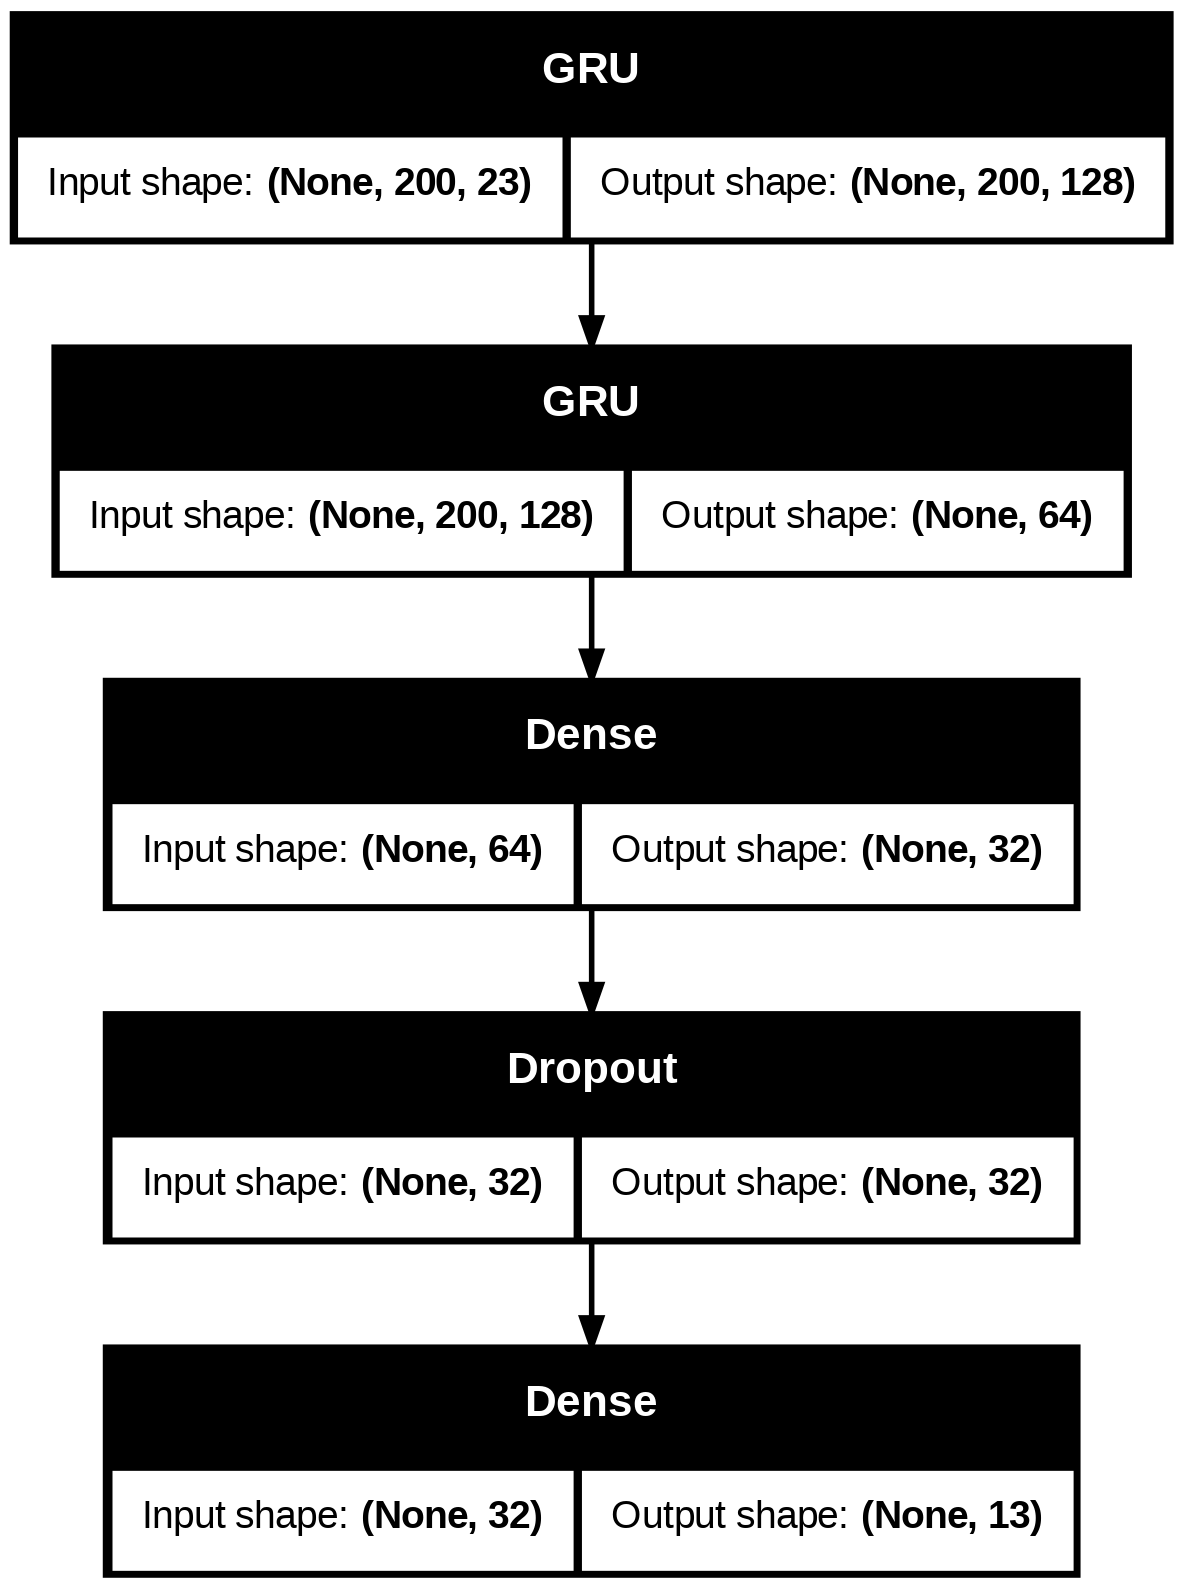

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "mhealth_GRU_best.h5",
                save_best_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.0017 - sparse_categorical_accuracy: 0.3470
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.68835, saving model to mhealth_GRU_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 1.9950 - sparse_categorical_accuracy: 0.3493 - val_loss: 0.9706 - val_sparse_categorical_accuracy: 0.6884
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9066 - sparse_categorical_accuracy: 0.7080
Epoch 2: val_sparse_categorical_accuracy improved from 0.68835 to 0.78075, saving model to mhealth_GRU_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.9057 - sparse_categorical_accuracy: 0.7084 - val_loss: 0.7010 - val_sparse_categorical_accuracy: 0.7808
Epoch 3/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4729 - sparse_categorical_accuracy: 0.8846
Epoch 3: val_sparse_categorical_accuracy improved from 0.78075 to 0.91908, saving model to mhealth_GRU_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.4723 - sparse_categorical_accuracy: 0.8848 - val_loss: 0.2871 - val_sparse_categorical_accuracy: 0.9191
Epoch 4/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2823 - sparse_categorical_accuracy: 0.9323
Epoch 4: val_sparse_categorical_accuracy did not improve from 0.91908
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.2825 - sparse_categorical_accuracy: 0.9322 - val_loss: 0.3956 - val_sparse_categorical_accuracy: 0.8781
Epoch 5/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2450 - sparse_categorical_accuracy: 0.9427
Epoch 5: val_sparse_categorical_accuracy improved from 0.91908 to 0.93494, saving model to mhealth_GRU_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.2444 - sparse_categorical_accuracy: 0.9429 - val_loss: 0.1963 - val_sparse_categorical_accuracy: 0.9349
Epoch 6/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1694 - sparse_categorical_accuracy: 0.9610
Epoch 6: val_sparse_categorical_accuracy did not improve from 0.93494
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1694 - sparse_categorical_accuracy: 0.9610 - val_loss: 0.5701 - val_sparse_categorical_accuracy: 0.8781
Epoch 7/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.9650
Epoch 7: val_sparse_categorical_accuracy improved from 0.93494 to 0.96555, saving model to mhealth_GRU_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.1446 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.1385 - val_sparse_categorical_accuracy: 0.9656
Epoch 8/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1772 - sparse_categorical_accuracy: 0.9570
Epoch 8: val_sparse_categorical_accuracy improved from 0.96555 to 0.96884, saving model to mhealth_GRU_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1770 - sparse_categorical_accuracy: 0.9570 - val_loss: 0.1526 - val_sparse_categorical_accuracy: 0.9688
Epoch 9/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1005 - sparse_categorical_accuracy: 0.9773
Epoch 9: val_sparse_categorical_accuracy did not improve from 0.96884
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.1008 - sparse_categorical_accuracy: 0.9772 - val_loss: 0.3412 - val_sparse_categorical_accuracy: 0.9306
Epoch 10/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1077 - sparse_categorical_accuracy: 0.9729
Epoch 10: val_sparse_categorical_accuracy did not improve from 0.96884
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1077 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.2068 - val_sparse_categorical_accuracy: 0.9420
Epoch 11/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1149 - sparse_categorical_accuracy: 0.9748
Epoch 11: val_sparse_categorical_accuracy did not improve from 0.968

177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0687 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.0868 - val_sparse_categorical_accuracy: 0.9814
Epoch 14/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0715 - sparse_categorical_accuracy: 0.9837
Epoch 14: val_sparse_categorical_accuracy did not improve from 0.98141
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0715 - sparse_categorical_accuracy: 0.9837 - val_loss: 0.1393 - val_sparse_categorical_accuracy: 0.9677
Epoch 15/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0649 - sparse_categorical_accuracy: 0.9816
Epoch 15: val_sparse_categorical_accuracy did not improve from 0.98141
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0651 - sparse_categorical_accuracy: 0.9816 - val_loss: 0.1087 - val_sparse_categorical_accuracy: 0.9765
Epoch 16/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0738 - sparse_categorical_accuracy: 0.9809
Epoch 16: val_sparse_categorical_accuracy did not improve from 0.9

177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0499 - sparse_categorical_accuracy: 0.9875 - val_loss: 0.0863 - val_sparse_categorical_accuracy: 0.9836
Epoch 30/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0434 - sparse_categorical_accuracy: 0.9891
Epoch 30: val_sparse_categorical_accuracy did not improve from 0.98360
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0434 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.1972 - val_sparse_categorical_accuracy: 0.9513
Epoch 31/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0545 - sparse_categorical_accuracy: 0.9865
Epoch 31: val_sparse_categorical_accuracy did not improve from 0.98360
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.2058 - val_sparse_categorical_accuracy: 0.9420
Epoch 32/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0427 - sparse_categorical_accuracy: 0.9890
Epoch 32: val_sparse_categorical_accuracy did not improve from 0.9

177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0454 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.0769 - val_sparse_categorical_accuracy: 0.9852
Epoch 37/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0339 - sparse_categorical_accuracy: 0.9921
Epoch 37: val_sparse_categorical_accuracy did not improve from 0.98524
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0340 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.1026 - val_sparse_categorical_accuracy: 0.9809
Epoch 38/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0380 - sparse_categorical_accuracy: 0.9922
Epoch 38: val_sparse_categorical_accuracy did not improve from 0.98524
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0381 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.2992 - val_sparse_categorical_accuracy: 0.9475
Epoch 39/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0395 - sparse_categorical_accuracy: 0.9881
Epoch 39: val_sparse_categorical_accuracy did not improve from 0.9

177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0361 - sparse_categorical_accuracy: 0.9923 - val_loss: 0.0997 - val_sparse_categorical_accuracy: 0.9869
Epoch 47/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0293 - sparse_categorical_accuracy: 0.9916
Epoch 47: val_sparse_categorical_accuracy did not improve from 0.98688
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0293 - sparse_categorical_accuracy: 0.9916 - val_loss: 0.4518 - val_sparse_categorical_accuracy: 0.9049
Epoch 48/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0436 - sparse_categorical_accuracy: 0.9894
Epoch 48: val_sparse_categorical_accuracy did not improve from 0.98688
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0436 - sparse_categorical_accuracy: 0.9894 - val_loss: 0.2111 - val_sparse_categorical_accuracy: 0.9415
Epoch 49/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0330 - sparse_categorical_accuracy: 0.9893
Epoch 49: val_sparse_categorical_accuracy did not improve from 0.9

In [ ]:
# 모델 평가
model = tf.keras.models.load_model("mhealth_GRU_best.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test_acc * 100:.2f}%")
print(f"Validation loss: {test_loss:.4f}")

Training accuracy: 99.65%
Training loss: 0.0073
Validation accuracy: 98.69%
Validation loss: 0.0997


In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_seq = y_test.flatten()

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9929    0.9964       140
           1     0.9935    0.9870    0.9902       154
           2     0.9928    0.8961    0.9420       154
           3     0.8994    0.9935    0.9441       153
           4     1.0000    0.9805    0.9902       154
           5     0.9747    1.0000    0.9872       154
           6     0.9779    1.0000    0.9888       133
           7     0.9857    0.9787    0.9822       141
           8     0.9926    0.9178    0.9537       146
           9     0.9387    1.0000    0.9684       153
          10     1.0000    0.9740    0.9868       154
          11     0.9806    0.9870    0.9838       154
          12     0.9608    1.0000    0.9800        49

    accuracy                         0.9761      1839
   macro avg     0.9767    0.9775    0.9765      1839
weighted avg     0.9773    0.9761    0.9760      1839



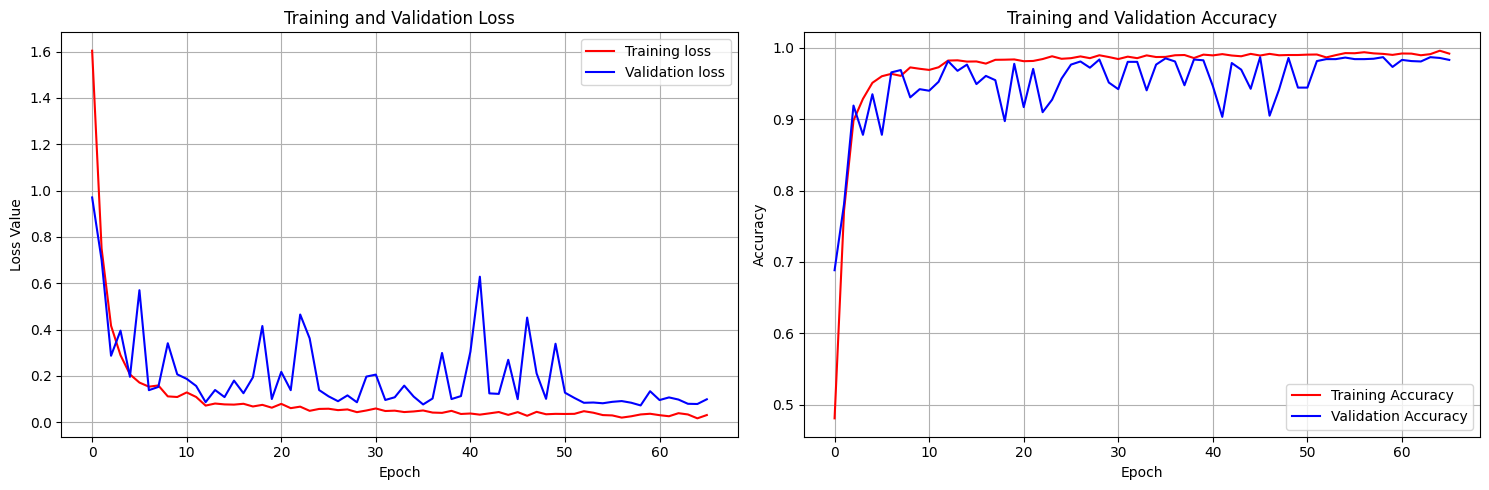

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

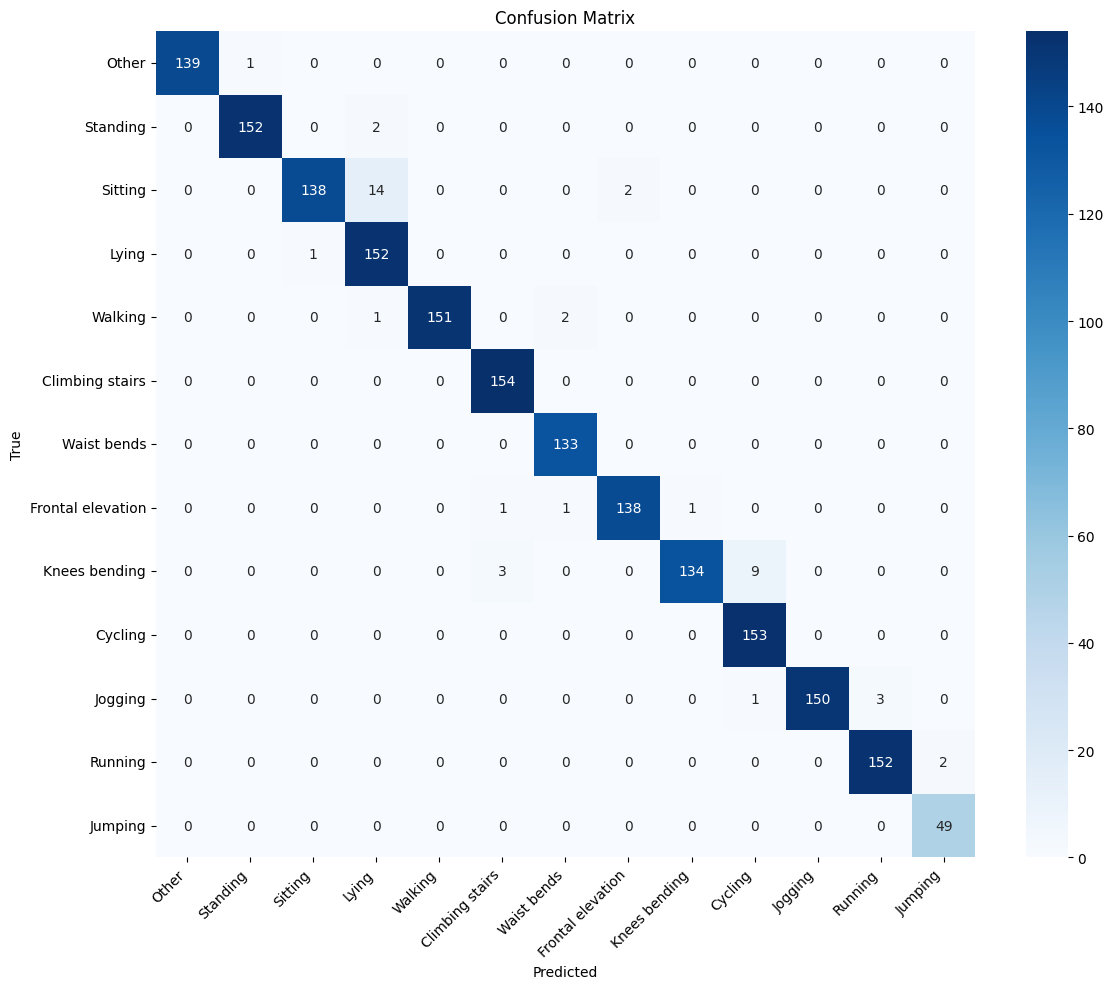

In [ ]:
cm = confusion_matrix(y_test_seq, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

activity_names = [
    'Other', 'Standing', 'Sitting', 'Lying', 'Walking',
    'Climbing stairs', 'Waist bends', 'Frontal elevation',
    'Knees bending', 'Cycling', 'Jogging', 'Running', 'Jumping'
]

n_classes = len(np.unique(y_test_seq))
if n_classes <= len(activity_names):
    plt.gca().set_xticklabels(activity_names[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(activity_names[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 2
- GRU layer 3

In [ ]:
input_shape = (200, 23)
num_classes = 13

model = Sequential([
            Input(shape=input_shape), # time_steps, n_features
            GRU(128, return_sequences=True, dropout=0.2),
            GRU(128, return_sequences=True, dropout=0.2),
            GRU(64, dropout=0.2),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 200, 128)       │        58,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 200, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,581 (771.80 KB)

 Trainable params: 197,581 (771.80 KB)

 Non-trainable params: 0 (0.00 B)

None


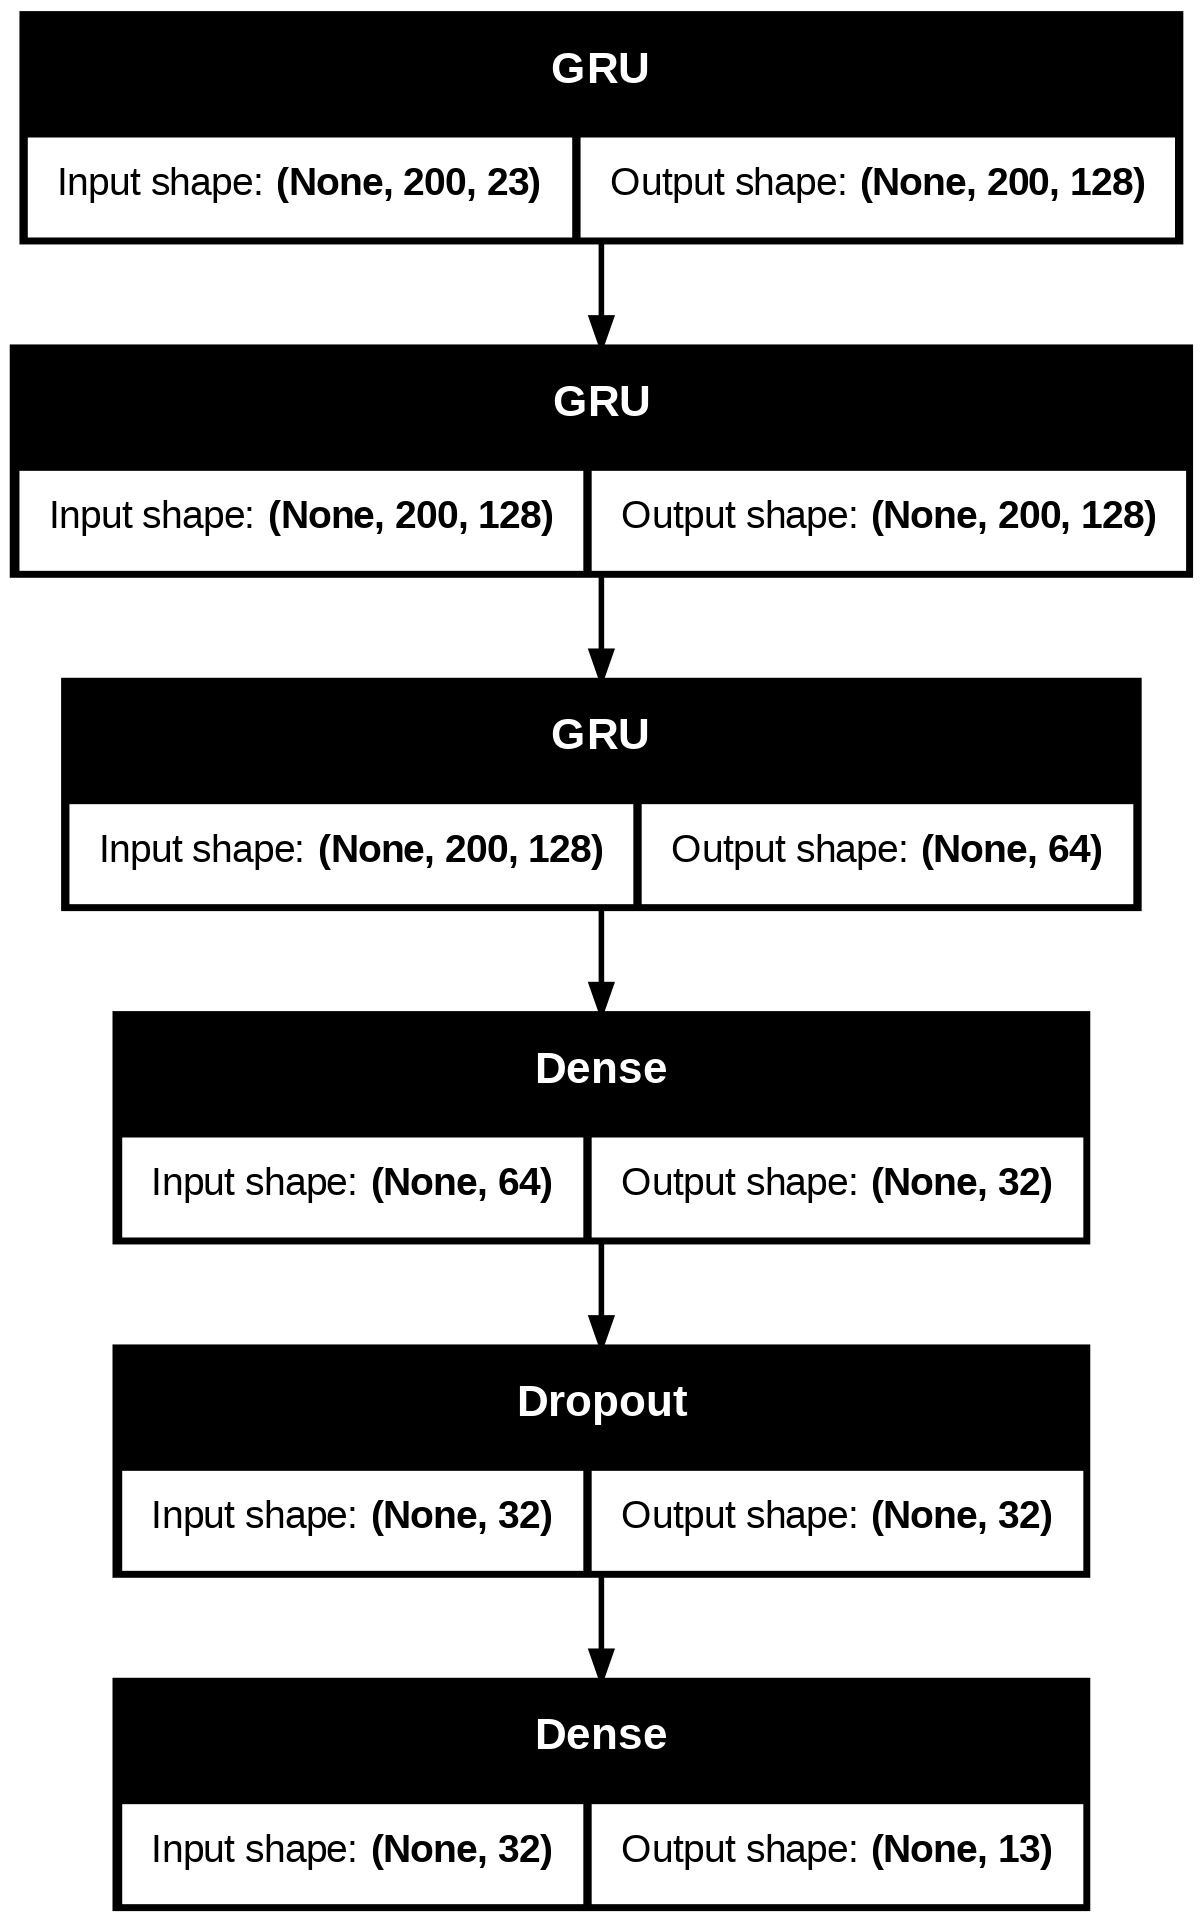

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "mhealth_GRU_best2.h5",
                save_best_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.8919 - sparse_categorical_accuracy: 0.3825
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.57900, saving model to mhealth_GRU_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 1.8896 - sparse_categorical_accuracy: 0.3832 - val_loss: 1.4058 - val_sparse_categorical_accuracy: 0.5790
Epoch 2/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7349 - sparse_categorical_accuracy: 0.7723
Epoch 2: val_sparse_categorical_accuracy improved from 0.57900 to 0.80809, saving model to mhealth_GRU_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7328 - sparse_categorical_accuracy: 0.7731 - val_loss: 0.6748 - val_sparse_categorical_accuracy: 0.8081
Epoch 3/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3803 - sparse_categorical_accuracy: 0.9031
Epoch 3: val_sparse_categorical_accuracy improved from 0.80809 to 0.86441, saving model to mhealth_GRU_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.3800 - sparse_categorical_accuracy: 0.9032 - val_loss: 0.5738 - val_sparse_categorical_accuracy: 0.8644
Epoch 4/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2776 - sparse_categorical_accuracy: 0.9314
Epoch 4: val_sparse_categorical_accuracy improved from 0.86441 to 0.93767, saving model to mhealth_GRU_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.2775 - sparse_categorical_accuracy: 0.9315 - val_loss: 0.2268 - val_sparse_categorical_accuracy: 0.9377
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2419 - sparse_categorical_accuracy: 0.9399
Epoch 5: val_sparse_categorical_accuracy improved from 0.93767 to 0.97212, saving model to mhealth_GRU_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.2417 - sparse_categorical_accuracy: 0.9400 - val_loss: 0.1277 - val_sparse_categorical_accuracy: 0.9721
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1805 - sparse_categorical_accuracy: 0.9533
Epoch 6: val_sparse_categorical_accuracy improved from 0.97212 to 0.97868, saving model to mhealth_GRU_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1804 - sparse_categorical_accuracy: 0.9533 - val_loss: 0.0877 - val_sparse_categorical_accuracy: 0.9787
Epoch 7/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1326 - sparse_categorical_accuracy: 0.9693
Epoch 7: val_sparse_categorical_accuracy did not improve from 0.97868
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.1326 - sparse_categorical_accuracy: 0.9693 - val_loss: 0.2674 - val_sparse_categorical_accuracy: 0.9229
Epoch 8/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1789 - sparse_categorical_accuracy: 0.9588
Epoch 8: val_sparse_categorical_accuracy improved from 0.97868 to 0.98032, saving model to mhealth_GRU_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.1786 - sparse_categorical_accuracy: 0.9589 - val_loss: 0.0868 - val_sparse_categorical_accuracy: 0.9803
Epoch 9/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1148 - sparse_categorical_accuracy: 0.9759
Epoch 9: val_sparse_categorical_accuracy did not improve from 0.98032
177/177 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.1149 - sparse_categorical_accuracy: 0.9758 - val_loss: 0.4622 - val_sparse_categorical_accuracy: 0.9125
Epoch 10/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1567 - sparse_categorical_accuracy: 0.9660
Epoch 10: val_sparse_categorical_accuracy improved from 0.98032 to 0.98524, saving model to mhealth_GRU_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.9661 - val_loss: 0.0580 - val_sparse_categorical_accuracy: 0.9852
Epoch 11/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1355 - sparse_categorical_accuracy: 0.9688
Epoch 11: val_sparse_categorical_accuracy did not improve from 0.98524
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.1354 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.3304 - val_sparse_categorical_accuracy: 0.9229
Epoch 12/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0947 - sparse_categorical_accuracy: 0.9767
Epoch 12: val_sparse_categorical_accuracy did not improve from 0.98524
177/177 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0947 - sparse_categorical_accuracy: 0.9767 - val_loss: 0.1338 - val_sparse_categorical_accuracy: 0.9431
Epoch 13/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0956 - sparse_categorical_accuracy: 0.9779
Epoch 13: val_sparse_categorical_accuracy did not improve from 0.9

177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0536 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.0624 - val_sparse_categorical_accuracy: 0.9869
Epoch 23/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0437 - sparse_categorical_accuracy: 0.9883
Epoch 23: val_sparse_categorical_accuracy did not improve from 0.98688
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0438 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.0697 - val_sparse_categorical_accuracy: 0.9852
Epoch 24/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0655 - sparse_categorical_accuracy: 0.9857
Epoch 24: val_sparse_categorical_accuracy did not improve from 0.98688
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0655 - sparse_categorical_accuracy: 0.9857 - val_loss: 0.0653 - val_sparse_categorical_accuracy: 0.9858
Epoch 25/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0676 - sparse_categorical_accuracy: 0.9818
Epoch 25: val_sparse_categorical_accuracy improved from 0.98688 to

177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0675 - sparse_categorical_accuracy: 0.9818 - val_loss: 0.0610 - val_sparse_categorical_accuracy: 0.9880
Epoch 26/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0425 - sparse_categorical_accuracy: 0.9889
Epoch 26: val_sparse_categorical_accuracy did not improve from 0.98797
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0426 - sparse_categorical_accuracy: 0.9888 - val_loss: 0.0699 - val_sparse_categorical_accuracy: 0.9869
Epoch 27/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0485 - sparse_categorical_accuracy: 0.9874
Epoch 27: val_sparse_categorical_accuracy did not improve from 0.98797
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0485 - sparse_categorical_accuracy: 0.9874 - val_loss: 0.0791 - val_sparse_categorical_accuracy: 0.9831
Epoch 28/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0660 - sparse_categorical_accuracy: 0.9840
Epoch 28: val_sparse_categorical_accuracy did not improve from 0.9

177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.0311 - sparse_categorical_accuracy: 0.9909 - val_loss: 0.0587 - val_sparse_categorical_accuracy: 0.9885
Epoch 34/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0429 - sparse_categorical_accuracy: 0.9899
Epoch 34: val_sparse_categorical_accuracy did not improve from 0.98852
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0429 - sparse_categorical_accuracy: 0.9899 - val_loss: 0.0696 - val_sparse_categorical_accuracy: 0.9852
Epoch 35/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0638 - sparse_categorical_accuracy: 0.9827
Epoch 35: val_sparse_categorical_accuracy did not improve from 0.98852
177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.0637 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.0614 - val_sparse_categorical_accuracy: 0.9880
Epoch 36/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0359 - sparse_categorical_accuracy: 0.9906
Epoch 36: val_sparse_categorical_accuracy did not improve from 0

177/177 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 0.0414 - sparse_categorical_accuracy: 0.9876 - val_loss: 0.0424 - val_sparse_categorical_accuracy: 0.9907
Epoch 51/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0275 - sparse_categorical_accuracy: 0.9934
Epoch 51: val_sparse_categorical_accuracy did not improve from 0.99071
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0275 - sparse_categorical_accuracy: 0.9934 - val_loss: 0.1195 - val_sparse_categorical_accuracy: 0.9787
Epoch 52/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0348 - sparse_categorical_accuracy: 0.9911
Epoch 52: val_sparse_categorical_accuracy did not improve from 0.99071
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0351 - sparse_categorical_accuracy: 0.9911 - val_loss: 0.0811 - val_sparse_categorical_accuracy: 0.9852
Epoch 53/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0378 - sparse_categorical_accuracy: 0.9900
Epoch 53: val_sparse_categorical_accuracy did not improve from 0.

177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0289 - sparse_categorical_accuracy: 0.9912 - val_loss: 0.0543 - val_sparse_categorical_accuracy: 0.9913
Epoch 55/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0212 - sparse_categorical_accuracy: 0.9934
Epoch 55: val_sparse_categorical_accuracy did not improve from 0.99125
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0213 - sparse_categorical_accuracy: 0.9934 - val_loss: 0.0722 - val_sparse_categorical_accuracy: 0.9858
Epoch 56/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0437 - sparse_categorical_accuracy: 0.9888
Epoch 56: val_sparse_categorical_accuracy did not improve from 0.99125
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0436 - sparse_categorical_accuracy: 0.9888 - val_loss: 0.0636 - val_sparse_categorical_accuracy: 0.9891
Epoch 57/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0260 - sparse_categorical_accuracy: 0.9917
Epoch 57: val_sparse_categorical_accuracy did not improve from 0.9

In [ ]:
# 모델 평가
model = tf.keras.models.load_model("mhealth_GRU_best2.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test_acc * 100:.2f}%")
print(f"Validation loss: {test_loss:.4f}")

Training accuracy: 99.79%
Training loss: 0.0051
Validation accuracy: 99.13%
Validation loss: 0.0543


In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_seq = y_test.flatten()

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9929    0.9964       140
           1     0.9935    0.9935    0.9935       154
           2     0.9448    1.0000    0.9716       154
           3     0.9934    0.9869    0.9902       153
           4     1.0000    0.9870    0.9935       154
           5     1.0000    1.0000    1.0000       154
           6     0.8313    1.0000    0.9078       133
           7     1.0000    0.9929    0.9964       141
           8     0.9906    0.7192    0.8333       146
           9     0.9444    1.0000    0.9714       153
          10     0.9935    0.9935    0.9935       154
          11     0.9935    0.9935    0.9935       154
          12     1.0000    1.0000    1.0000        49

    accuracy                         0.9728      1839
   macro avg     0.9758    0.9738    0.9724      1839
weighted avg     0.9756    0.9728    0.9718      1839



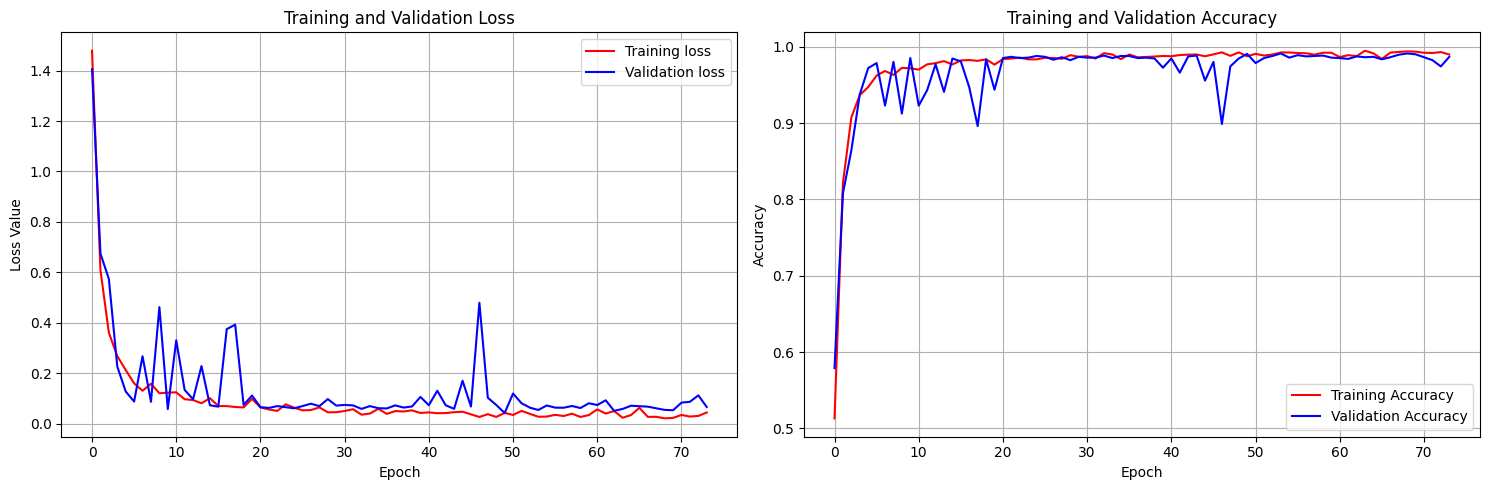

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

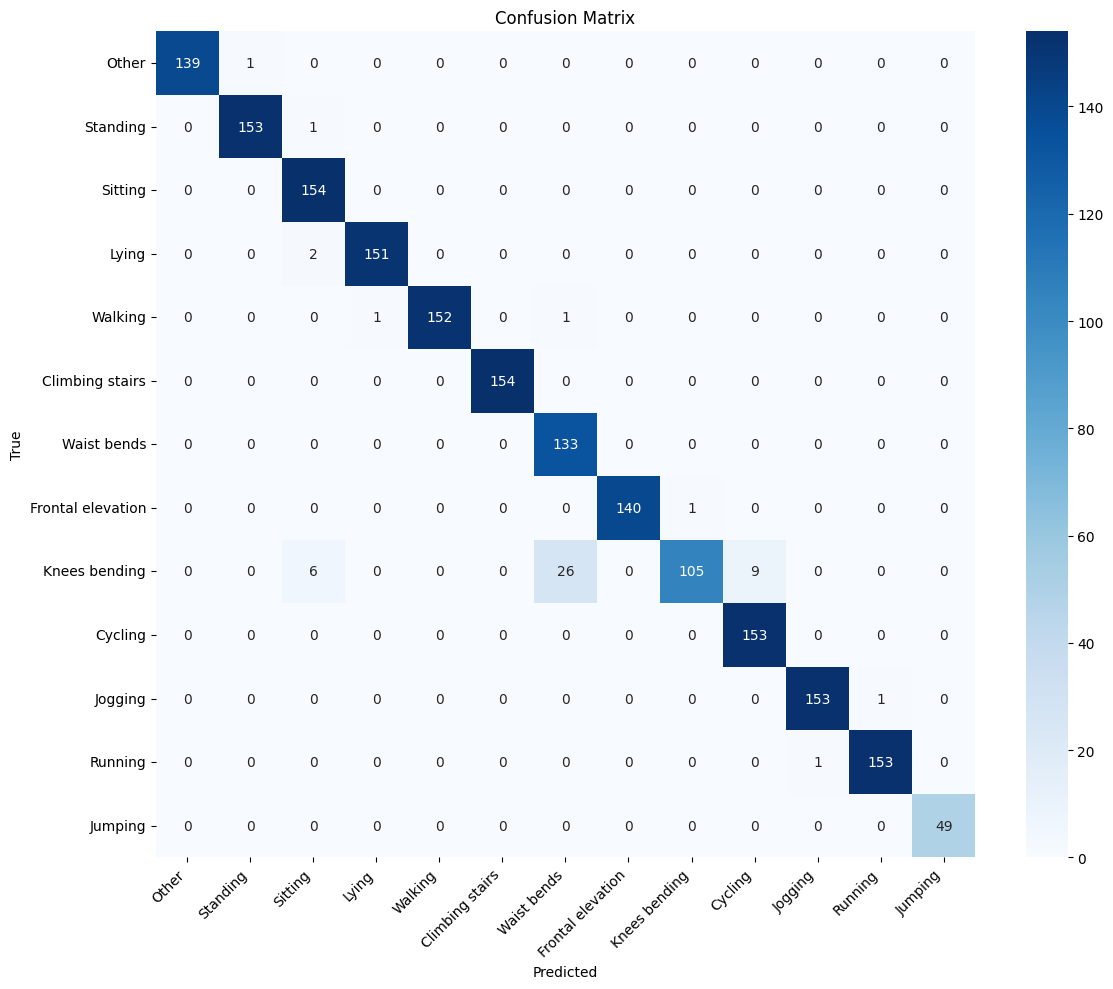

In [ ]:
cm = confusion_matrix(y_test_seq, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

activity_names = [
    'Other', 'Standing', 'Sitting', 'Lying', 'Walking',
    'Climbing stairs', 'Waist bends', 'Frontal elevation',
    'Knees bending', 'Cycling', 'Jogging', 'Running', 'Jumping'
]

n_classes = len(np.unique(y_test_seq))
if n_classes <= len(activity_names):
    plt.gca().set_xticklabels(activity_names[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(activity_names[:n_classes], rotation=0)

plt.tight_layout()
plt.show()